In [21]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import joblib as jbl

In [85]:
col_sales = ['id', 'list_id', 'seller_id', 'buyer_id', 'event_id', 'date_id', 'qt_sold', 'price_paid', 'commission', 'saletime']
col_sales_t = [np.int32, np.int32, np.int32, np.int32, np.int32, np.int32, np.int8, np.float32, np.float32]
col_sales_=col_sales[:-1]
dict_types = dict(zip(col_sales, col_sales_t))
sales: pd.DataFrame = pd.read_csv(filepath_or_buffer='data/sales_tab.txt', sep='\t', names=col_sales, index_col=0, parse_dates=['saletime'], infer_datetime_format=True, dtype=dict_types)
sales.head(5)

,list_id,seller_id,buyer_id,event_id,date_id,qt_sold,price_paid,commission,saletime
id,,,,,,,,,
1,1,36861,21191,7872,1875,4,728.0,109.199997,2008-02-18 02:36:48
2,4,8117,11498,4337,1983,2,76.0,11.400000,2008-06-06 05:00:16
3,5,1616,17433,8647,1983,2,350.0,52.500000,2008-06-06 08:26:17
4,5,1616,19715,8647,1986,1,175.0,26.250000,2008-06-09 08:38:52
5,6,47402,14115,8240,2069,2,154.0,23.100000,2008-08-31 09:17:02


In [86]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172456 entries, 1 to 172456
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   list_id     172456 non-null  int32         
 1   seller_id   172456 non-null  int32         
 2   buyer_id    172456 non-null  int32         
 3   event_id    172456 non-null  int32         
 4   date_id     172456 non-null  int32         
 5   qt_sold     172456 non-null  int8          
 6   price_paid  172456 non-null  float32       
 7   commission  172456 non-null  float32       
 8   saletime    172456 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float32(2), int32(5), int8(1)
memory usage: 7.4 MB


In [87]:
def formmating_date(dat: np.datetime64):
    if isinstance(dat, datetime):
        return dat.date()
    else:
        raise TypeError(f'Error en /{dat}/')

sales['saletime'] = pd.to_datetime(arg=sales['saletime'].map(formmating_date))

sales.head(5)


,list_id,seller_id,buyer_id,event_id,date_id,qt_sold,price_paid,commission,saletime
id,,,,,,,,,
1,1,36861,21191,7872,1875,4,728.0,109.199997,2008-02-18
2,4,8117,11498,4337,1983,2,76.0,11.400000,2008-06-06
3,5,1616,17433,8647,1983,2,350.0,52.500000,2008-06-06
4,5,1616,19715,8647,1986,1,175.0,26.250000,2008-06-09
5,6,47402,14115,8240,2069,2,154.0,23.100000,2008-08-31


In [88]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172456 entries, 1 to 172456
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   list_id     172456 non-null  int32         
 1   seller_id   172456 non-null  int32         
 2   buyer_id    172456 non-null  int32         
 3   event_id    172456 non-null  int32         
 4   date_id     172456 non-null  int32         
 5   qt_sold     172456 non-null  int8          
 6   price_paid  172456 non-null  float32       
 7   commission  172456 non-null  float32       
 8   saletime    172456 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float32(2), int32(5), int8(1)
memory usage: 7.4 MB


## revision evento 7872

In [6]:
ev_7872 = sales[sales['event_id'] == 7872]
s_7872 = ev_7872['saletime'].value_counts().sort_index()
print(s_7872.shape)
print(s_7872)

(18,)
2008-01-06    1
2008-01-18    1
2008-01-20    1
2008-01-23    1
2008-01-25    2
2008-01-28    1
2008-01-30    1
2008-01-31    2
2008-02-05    1
2008-02-07    1
2008-02-08    2
2008-02-11    1
2008-02-13    2
2008-02-17    1
2008-02-18    1
2008-02-19    1
2008-02-20    1
2008-02-21    1
Name: saletime, dtype: int64


## Evento 7874

In [7]:
ev_7874 = sales[sales['event_id'] == 7874]
s_7874 = ev_7874['saletime'].value_counts().sort_index()
print(s_7874.shape)
print(s_7874)

(17,)
2008-10-30    1
2008-11-03    1
2008-11-05    1
2008-11-18    1
2008-11-21    1
2008-11-22    1
2008-11-27    1
2008-11-30    1
2008-12-01    3
2008-12-08    1
2008-12-09    4
2008-12-10    1
2008-12-11    2
2008-12-12    1
2008-12-16    1
2008-12-17    1
2008-12-19    1
Name: saletime, dtype: int64


## Ventas por evento

In [89]:
ventas_por_evento = sales.groupby(by=['event_id'])['qt_sold'].sum()
print(f'Descripción:\n{ventas_por_evento.describe()}\n')
print(f'Agrupamiento:\n{ventas_por_evento.reset_index().rename(columns={"event_id": "event_id", "commission": "Boletos vendidos"})}')

Descripción:
count    8512.000000
mean       40.572016
std        17.441929
min         1.000000
25%        30.000000
50%        41.000000
75%        52.000000
max       122.000000
Name: qt_sold, dtype: float64

Agrupamiento:
      event_id  qt_sold
0            1        3
1            2       45
2            3       38
3            4       45
4            5       27
...        ...      ...
8507      8794       37
8508      8795       27
8509      8796       47
8510      8797       54
8511      8798       45

[8512 rows x 2 columns]


## Ventas por fecha

In [90]:
ventas_por_fecha = sales.groupby(by=['saletime'])['qt_sold'].sum()
print(f'Descripción:\n{ventas_por_fecha.describe()}\n')
ventas_fecha_index = ventas_por_fecha.reset_index().rename(columns={'saletime': 'saletime', 'qt_sold': 'boletos_vendidos'})
print(f"Ventas por fecha:\n{ventas_fecha_index}\n")

Descripción:
count     365.000000
mean      946.161644
std       244.505362
min        19.000000
25%       962.000000
50%      1033.000000
75%      1079.000000
max      1216.000000
Name: qt_sold, dtype: float64

Ventas por fecha:
      saletime  boletos_vendidos
0   2008-01-01              19.0
1   2008-01-02              57.0
2   2008-01-03              94.0
3   2008-01-04             157.0
4   2008-01-05             210.0
..         ...               ...
360 2008-12-27             170.0
361 2008-12-28             145.0
362 2008-12-29             143.0
363 2008-12-30              76.0
364 2008-12-31              42.0

[365 rows x 2 columns]



In [91]:
#Carga de tabla de tiempo
col_date = ['id', 'date', 'day','week', 'month', 'qtr', 'year', 'holiday']
col_date_ = col_date.copy()
col_date_.pop(1)
col_date_t = ['Int64', 'string', 'Int16', 'string', 'string', 'Int16', 'boolean']

dict_types_date = dict(zip(col_date_, col_date_t))

date = pd.read_csv(filepath_or_buffer='data/date2008_pipe.txt', sep='|', names=col_date, dtype=dict_types_date, index_col=False, parse_dates=['date'], infer_datetime_format=True)
print(date.head(10))
print(f'\n{date.info()}')

     id       date day  week month qtr  year  holiday
0  1827 2008-01-01  WE     1   JAN   1  2008     True
1  1828 2008-01-02  TH     1   JAN   1  2008    False
2  1829 2008-01-03  FR     1   JAN   1  2008    False
3  1830 2008-01-04  SA     2   JAN   1  2008    False
4  1831 2008-01-05  SU     2   JAN   1  2008    False
5  1832 2008-01-06  MO     2   JAN   1  2008    False
6  1833 2008-01-07  TU     2   JAN   1  2008    False
7  1834 2008-01-08  WE     2   JAN   1  2008    False
8  1835 2008-01-09  TH     2   JAN   1  2008    False
9  1836 2008-01-10  FR     2   JAN   1  2008    False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   id       365 non-null    Int64         
 1   date     365 non-null    datetime64[ns]
 2   day      365 non-null    string        
 3   week     365 non-null    Int16         
 4   month    365 non-null    st

Descripcion festivos
count       7.000000
mean      654.428571
std       488.121862
min        19.000000
25%       211.000000
50%       848.000000
75%      1067.000000
max      1158.000000
Name: boletos_vendidos, dtype: float64

Descripcion no festivos
count     358.000000
mean      951.865922
std       235.051586
min        42.000000
25%       965.750000
50%      1033.500000
75%      1079.000000
max      1216.000000
Name: boletos_vendidos, dtype: float64


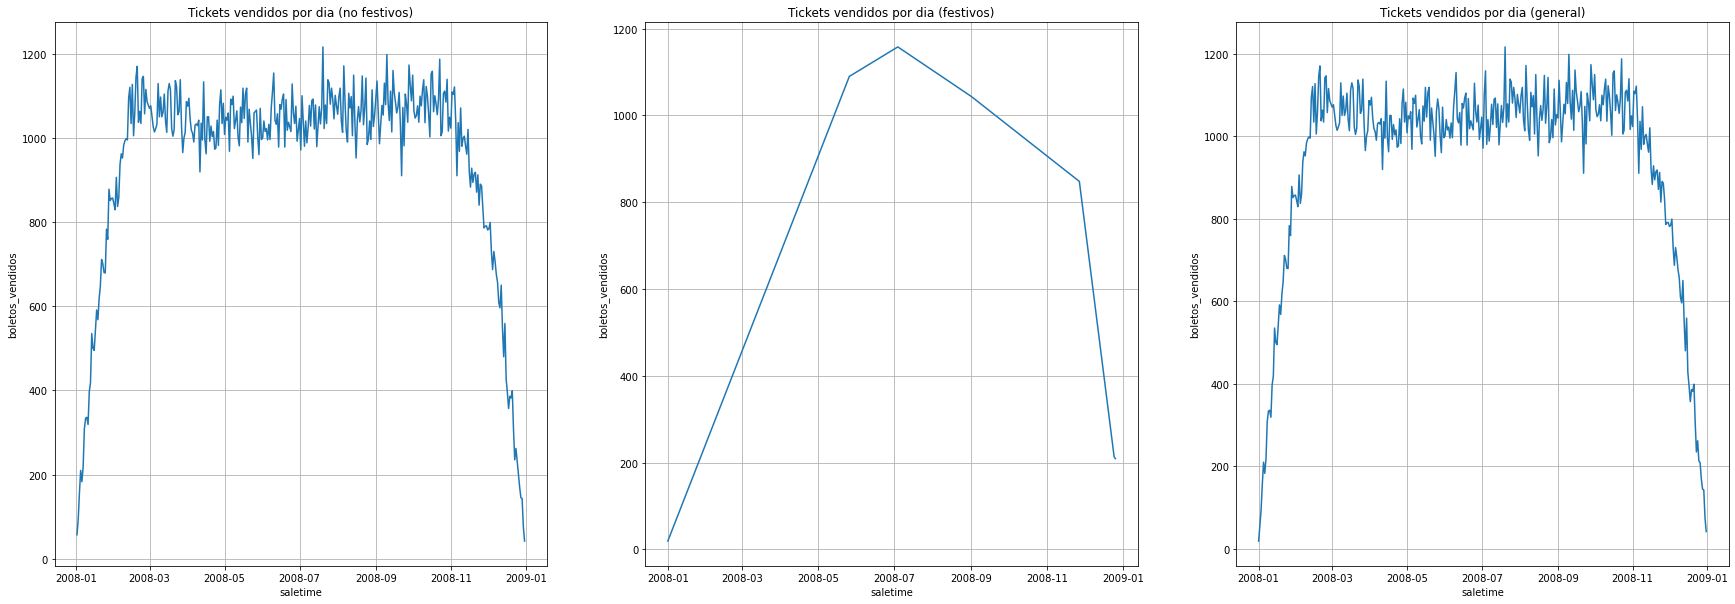

In [92]:
# append de tabla date con sales para dias festivos

merge_1 = pd.merge(left=ventas_fecha_index, right=date, left_on='saletime', right_on='date')[['saletime', 'boletos_vendidos', 'holiday']]
merge_1

ventas_festivos = merge_1.loc[merge_1['holiday'] == True]
ventas_no_festivos = merge_1.loc[merge_1['holiday'] == False]

print(f'Descripcion festivos\n{ventas_festivos["boletos_vendidos"].describe()}\n')
print(f'Descripcion no festivos\n{ventas_no_festivos["boletos_vendidos"].describe()}')


fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(30,10))
ax[0].set_title('Tickets vendidos por dia (no festivos)')
ax[1].set_title('Tickets vendidos por dia (festivos)')
ax[2].set_title('Tickets vendidos por dia (general)')
sns.lineplot(data=ventas_no_festivos, x='saletime', y='boletos_vendidos', ax=ax[0])
sns.lineplot(data=ventas_festivos, x='saletime', y='boletos_vendidos', ax=ax[1])
sns.lineplot(data=merge_1, x='saletime', y='boletos_vendidos', ax=ax[2])
ax[0].grid()
ax[1].grid()
ax[2].grid()


## Configuracion de set inicial

In [94]:
serie_inicial = merge_1['boletos_vendidos'].squeeze()
serie_inicial.index = merge_1['saletime']
serie_inicial

saletime
2008-01-01     19.0
2008-01-02     57.0
2008-01-03     94.0
2008-01-04    157.0
2008-01-05    210.0
              ...  
2008-12-27    170.0
2008-12-28    145.0
2008-12-29    143.0
2008-12-30     76.0
2008-12-31     42.0
Name: boletos_vendidos, Length: 365, dtype: float64

### Particion en test y prueba

In [96]:
k = 15 # ventana temporal
data_train = serie_inicial.loc[:'2008-09-30']
data_test = serie_inicial.loc['2008-09-30':]

print(f'Limite superior set de prueba: {data_train.index[-1]}')
print(f'Limite inferior set de test: {data_train.index[0]}')
print(f'Limite inferior set de test: {data_train.shape}')

Limite superior set de prueba: 2008-09-30 00:00:00
Limite inferior set de test: 2008-01-01 00:00:00
Limite inferior set de test: (273,)


In [97]:
# Se crean los sets por medio de funcion de slide
def slide_serie(ts, window_size=10):
  '''
  Funcion encargada de crear dataset tipo 
  '''
  n = ts.shape[0] - window_size  
  X = np.empty((n, window_size))
  y = np.empty(n)

  for i in range(window_size, ts.shape[0]):   
    y[i - window_size] = ts[i]
    X[i- window_size, 0:window_size] = np.array(ts[i - window_size:i])
    
  return X, y

def scale_set(data, scaler_set=None):
  if scaler_set:
    pass
  else:
    scaler_set = StandardScaler()
  
  dt = data.reshape((data.shape[0],1))
  dt_ex = scaler_set.fit_transform(dt)
  data_sc = dt_ex.reshape((data.shape[0],))

  return (scaler_set, data_sc)


scaler_set, data_train_pr = scale_set(data_train.values)
_, data_test_pr = scale_set(data_test.values, scaler_set)

X_train, y_train = slide_serie(data_train_pr, window_size=k)
X_test, y_test = slide_serie(data_test_pr, window_size=k) 

In [98]:
print(f'Set de entrenamiento\nX:\tTamanio: {X_train.shape}\n{pd.DataFrame(X_train).head(5)}\nY:\tTamanio: {y_train.shape}\n{pd.DataFrame(y_train).head(5)}\n')
print(f'Set de prueba\nX:\tTamanio: {X_test.shape}\n{pd.DataFrame(X_test).head(5)}\nY:\tTamanio: {y_test.shape}\n{pd.DataFrame(y_test).head(5)}\n')

Set de entrenamiento
X:	Tamanio: (258, 15)
         0         1         2         3         4         5         6   \
0 -4.745058 -4.558627 -4.377103 -4.068022 -3.808000 -3.940464 -3.768752   
1 -4.558627 -4.377103 -4.068022 -3.808000 -3.940464 -3.768752 -3.327207   
2 -4.377103 -4.068022 -3.808000 -3.940464 -3.768752 -3.327207 -3.199649   
3 -4.068022 -3.808000 -3.940464 -3.768752 -3.327207 -3.199649 -3.189837   
4 -3.808000 -3.940464 -3.768752 -3.327207 -3.199649 -3.189837 -3.273240   

         7         8         9         10        11        12        13  \
0 -3.327207 -3.199649 -3.189837 -3.273240 -2.890567 -2.782634 -2.213531   
1 -3.199649 -3.189837 -3.273240 -2.890567 -2.782634 -2.213531 -2.385243   
2 -3.189837 -3.273240 -2.890567 -2.782634 -2.213531 -2.385243 -2.409774   
3 -3.273240 -2.890567 -2.782634 -2.213531 -2.385243 -2.409774 -2.164471   
4 -2.890567 -2.782634 -2.213531 -2.385243 -2.409774 -2.164471 -1.938792   

         14  
0 -2.385243  
1 -2.409774  
2 -2.164471  

In [99]:
# parámetros de modelo (MLPR) y GS

tsp = TimeSeriesSplit(n_splits = 5)

params_grid = {    
      'hidden_layer_sizes' : [(10,), (20,), (40,), (80,)], 
      'activation' : ['logistic', 'tanh', 'relu']
 }

grid_sh = GridSearchCV(estimator = MLPRegressor(solver = 'lbfgs', #Modelo  a explorar.          
                                                random_state=1234,
                                                max_iter= 2000,
                                                n_iter_no_change=50, 
                                                validation_fraction=0.2), 
                        cv = tsp,
                        param_grid = params_grid, 
                        verbose = 3,
                        scoring='neg_root_mean_squared_error',
                        )

grid_sh.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END activation=logistic, hidden_layer_sizes=(10,);, score=-0.657 total time=   1.1s
[CV 2/5] END activation=logistic, hidden_layer_sizes=(10,);, score=-0.422 total time=   0.5s
[CV 3/5] END activation=logistic, hidden_layer_sizes=(10,);, score=-0.432 total time=   0.7s
[CV 4/5] END activation=logistic, hidden_layer_sizes=(10,);, score=-0.510 total time=   0.9s
[CV 5/5] END activation=logistic, hidden_layer_sizes=(10,);, score=-0.667 total time=   0.9s
[CV 1/5] END activation=logistic, hidden_layer_sizes=(20,);, score=-1.046 total time=   0.2s
[CV 2/5] END activation=logistic, hidden_layer_sizes=(20,);, score=-0.566 total time=   0.5s
[CV 3/5] END activation=logistic, hidden_layer_sizes=(20,);, score=-0.513 total time=   0.7s
[CV 4/5] END activation=logistic, hidden_layer_sizes=(20,);, score=-0.779 total time=   0.8s
[CV 5/5] END activation=logistic, hidden_layer_sizes=(20,);, score=-0.642 total time=   1.2s
[CV 1/5] 

/home/leonardo/anaconda3/envs/DEV_ML_SKLEARN/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=tanh, hidden_layer_sizes=(10,);, score=-0.627 total time=   1.4s
[CV 1/5] END activation=tanh, hidden_layer_sizes=(20,);, score=-0.792 total time=   0.2s
[CV 2/5] END activation=tanh, hidden_layer_sizes=(20,);, score=-0.432 total time=   0.4s
[CV 3/5] END activation=tanh, hidden_layer_sizes=(20,);, score=-0.366 total time=   0.5s
[CV 4/5] END activation=tanh, hidden_layer_sizes=(20,);, score=-0.449 total time=   0.7s
[CV 5/5] END activation=tanh, hidden_layer_sizes=(20,);, score=-0.650 total time=   0.8s
[CV 1/5] END activation=tanh, hidden_layer_sizes=(40,);, score=-0.778 total time=   0.2s
[CV 2/5] END activation=tanh, hidden_layer_sizes=(40,);, score=-0.421 total time=   0.5s
[CV 3/5] END activation=tanh, hidden_layer_sizes=(40,);, score=-0.403 total time=   0.6s
[CV 4/5] END activation=tanh, hidden_layer_sizes=(40,);, score=-0.465 total time=   0.8s
[CV 5/5] END activation=tanh, hidden_layer_sizes=(40,);, score=-0.525 total time=   1.0s
[CV 1/5] END activati

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=MLPRegressor(max_iter=2000, n_iter_no_change=50,
                                    random_state=1234, solver='lbfgs',
                                    validation_fraction=0.2),
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(10,), (20,), (40,), (80,)]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [100]:
pd.DataFrame(grid_sh.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.818489,0.196084,0.000860,0.000257,logistic,"(10,)","{'activation': 'logistic', 'hidden_layer_sizes...",-0.657366,-0.421523,-0.431533,-0.510225,-0.666865,-0.537502,0.106326,6
1,0.668413,0.313523,0.000675,0.000104,logistic,"(20,)","{'activation': 'logistic', 'hidden_layer_sizes...",-1.045576,-0.565705,-0.512885,-0.779190,-0.642116,-0.709094,0.190619,12
2,0.820244,0.278043,0.000706,0.000170,logistic,"(40,)","{'activation': 'logistic', 'hidden_layer_sizes...",-0.930756,-0.424970,-0.455886,-0.451125,-0.484446,-0.549437,0.191592,8
3,2.540263,1.441200,0.000946,0.000277,logistic,"(80,)","{'activation': 'logistic', 'hidden_layer_sizes...",-0.937805,-0.520808,-0.439345,-0.549406,-0.516927,-0.592858,0.176295,10
4,0.727913,0.424975,0.000681,0.000154,tanh,"(10,)","{'activation': 'tanh', 'hidden_layer_sizes': (...",-0.524998,-0.650419,-0.442307,-0.653482,-0.626864,-0.579614,0.083113,9
5,0.493109,0.201116,0.000621,0.000014,tanh,"(20,)","{'activation': 'tanh', 'hidden_layer_sizes': (...",-0.792466,-0.431699,-0.365863,-0.448866,-0.650310,-0.537841,0.158898,7
6,0.620478,0.277472,0.000647,0.000005,tanh,"(40,)","{'activation': 'tanh', 'hidden_layer_sizes': (...",-0.778306,-0.420693,-0.403051,-0.464882,-0.525175,-0.518421,0.136611,4
7,1.963138,1.284344,0.001150,0.000203,tanh,"(80,)","{'activation': 'tanh', 'hidden_layer_sizes': (...",-0.950086,-0.427015,-0.370416,-0.422959,-0.503030,-0.534701,0.211953,5
8,0.632746,0.304552,0.000762,0.000208,relu,"(10,)","{'activation': 'relu', 'hidden_layer_sizes': (...",-1.089734,-0.546628,-0.509053,-0.368317,-0.472585,-0.597264,0.253311,11
9,0.460833,0.301415,0.000664,0.000094,relu,"(20,)","{'activation': 'relu', 'hidden_layer_sizes': (...",-0.650318,-0.326814,-0.373043,-0.455709,-0.645797,-0.490336,0.135247,3


### Predicciones

In [101]:
def inverse(data, scaler_set):
    yt = data.reshape((data.shape[0],1))
    yt_ex = scaler_set.inverse_transform(yt)
    
    return yt_ex.reshape((data.shape[0],))


y_predict = grid_sh.predict(X_test)

val = mean_squared_error(y_test, y_predict)
val


1.6856504486903718

(78,)
(78,)


<AxesSubplot:>

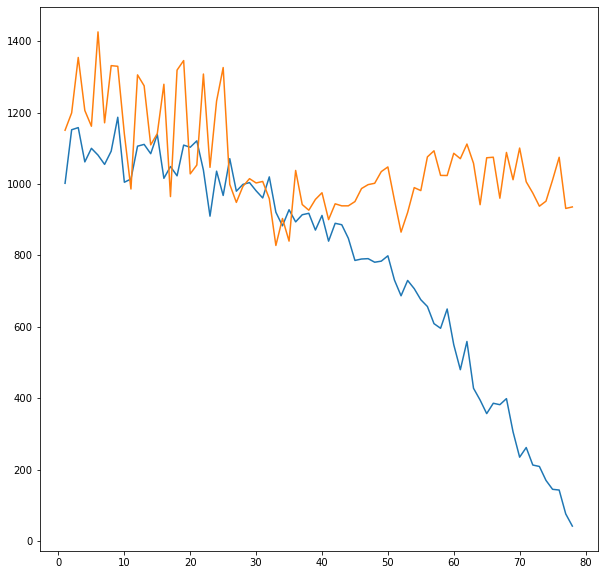

In [102]:
#grafica
y_test_de = inverse(y_test, scaler_set)
y_pred_de = inverse(y_predict, scaler_set)

print(y_test_de.shape)
print(y_pred_de.shape)

x = [i for i in range(1,79)]

fig, ax = plt.subplots(figsize=(10,10))
sns.lineplot(x=x, y=y_test_de,ax=ax)
sns.lineplot(x=x, y=y_pred_de,ax=ax)

In [103]:
#serializar regresor
jbl.dump(grid_sh, 'trainedModel.joblib')
#serializar scaler
jbl.dump(scaler_set, 'scaler.joblib')

['scaler.joblib']

In [104]:
#revision de tipos para realizar tipado en API
print(type(grid_sh))
print(type(scaler_set))

<class 'sklearn.model_selection._search.GridSearchCV'>
<class 'sklearn.preprocessing._data.StandardScaler'>


In [105]:
#Clase para condensar todo lo necesario para usar el regresor en API
class Predictor_utils:
    '''
    Clase usada para condensar atributos necesarios para usar un regresor previamente entrenado
    regresor: Regresor entrenado
    scaler: Scaler usado en el procesamiento de datos
    k: tamaño de ventana usado para generar dataset temporal con el que se entrenó el regresor
    window_data: Contiene k ultimos valores de la serie
    '''
    def __init__(self, regresor: GridSearchCV, scaler: StandardScaler, k: int, data: pd.Series):
        self.regresor = regresor
        self.scaler = scaler
        self.k = k
        self.window_data = data.iloc[-k:].values.reshape(-1,1)


In [106]:
#Instancia de Predictor_utils a serializar u serializacion

predictor_utils = Predictor_utils(grid_sh, scaler_set, k, serie_inicial)
jbl.dump(predictor_utils, 'regresor_utils.joblib')

['regresor_utils.joblib']

In [110]:
predictor_utils = {'regresor': grid_sh, 'scaler': scaler_set, 'k': k, 'window_data': serie_inicial.iloc[-k:].values.reshape(-1,1)} 

jbl.dump(predictor_utils, 'regresor_utils_.joblib')

['regresor_utils_.joblib']

In [108]:
predictor_utils.window_data[-2:]

array([[76.],
       [42.]])

In [109]:
serie_inicial.loc['2008-12-30':]

saletime
2008-12-30    76.0
2008-12-31    42.0
Name: boletos_vendidos, dtype: float64